COCO reduced dataset construction

The construction greatly referencing

Class Imbalance in Object Detection: An Experimental Diagnosis and Study of Mitigation Strategies

https://arxiv.org/html/2403.07113v1

We also selected top 10 classes from the COCO 2017 dataset, and we build an dataframe, indexing the related images, their path and appeared categories.

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train2017 = 'train2017'
val2017 = 'val2017'
ann_file = 'dataset/coco/annotations/instances_{}.json'

In [3]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])

In [4]:
coco_train = COCO(ann_file.format(train2017))
coco_val = COCO(ann_file.format(val2017))

loading annotations into memory...
Done (t=9.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [5]:
def get_coco_images_and_labels(coco, cat_ids=None):

    # get all filenames
    img_ids_w_filename = {coco.dataset['images'][i]['id']: coco.dataset['images'][i]['file_name'] for i in range(len(coco.dataset['images']))}      # use dictionary for faster query

    # get all images
    img_ids = [coco.dataset['images'][i]['id'] for i in range(len(coco.dataset['images']))]

    # load labels for each imgs (as one img may have multiple labels)
    labels_per_imgs = []
    for i in range(len(img_ids)):
        labels_per_imgs.append(coco.loadAnns(coco.getAnnIds(imgIds=img_ids[i])))

    img_id_w_bb = []
    label_per_obj = []

    if cat_ids == None:
        # get all images and their annotations
        for labels in labels_per_imgs:
            for l in labels:
                img_id_w_bb.append((l['id'], l['image_id'], l['bbox']))     # annotation id, image id, bounding box
                label_per_obj.append(l['category_id'])
    else:
        # only for selected categories
        for labels in labels_per_imgs:
            for l in labels:
                if l['category_id'] in cat_ids:
                    img_id_w_bb.append((l['id'], l['image_id'], l['bbox']))
                    label_per_obj.append(l['category_id'])

    return img_ids_w_filename, img_id_w_bb, label_per_obj

In [6]:
img_ids_w_filename_train, img_id_w_bb_train_top10, label_per_obj_train_top10 = get_coco_images_and_labels(coco_train, cat_ids=TOP_10_CATS_ID)
img_ids_w_filename_val, img_id_w_bb_val_top10, label_per_obj_val_top10 = get_coco_images_and_labels(coco_val, cat_ids=TOP_10_CATS_ID)

In [7]:
len(img_ids_w_filename_train), len(img_id_w_bb_train_top10), len(label_per_obj_train_top10), len(img_ids_w_filename_val), len(img_id_w_bb_val_top10), len(label_per_obj_val_top10)

(118287, 469840, 469840, 5000, 20312, 20312)

Show the class balance of both training and val set, plot a graph

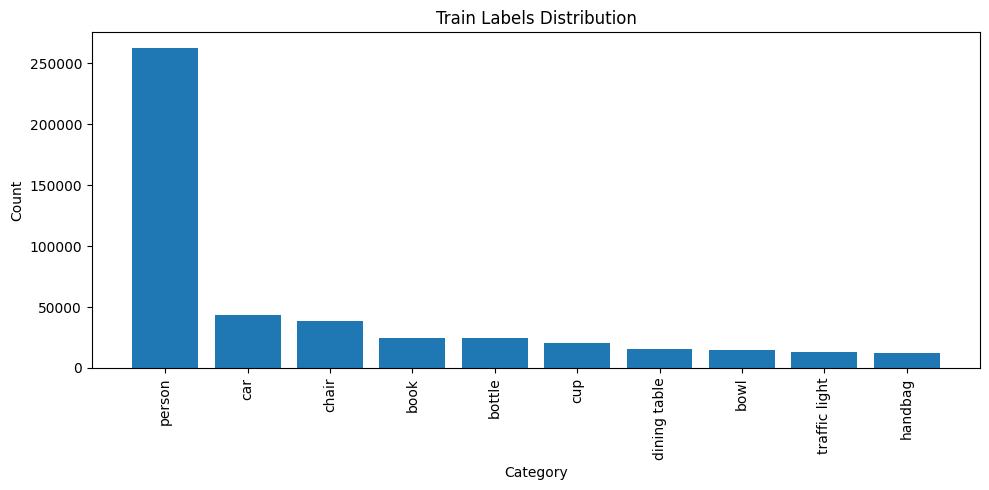

In [31]:
# plot a graph to see the distribution of labels
# with xticks as the category names

# all categories (with ids)
cats = coco_train.loadCats(coco_train.getCatIds())
cats_id_to_name = {cat['id']: cat['name'] for cat in cats}

# create a dataframe with the labels to store the count of each category and category name


df_label_per_obj_train = pd.DataFrame(label_per_obj_train_top10, columns=['category_id'])
df_label_per_obj_train['category_name'] = df_label_per_obj_train['category_id'].map(cats_id_to_name)
df_label_per_obj_train['count'] = 1
df_label_per_obj_train = df_label_per_obj_train.groupby(['category_id', 'category_name']).count().reset_index()
df_label_per_obj_train = df_label_per_obj_train.sort_values(by='count', ascending=False)

# plot the graph
plt.figure(figsize=(10, 5))
plt.bar(df_label_per_obj_train['category_name'], df_label_per_obj_train['count'])
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Train Labels Distribution')
plt.tight_layout()

In [33]:
df_label_per_obj_train

,category_id,category_name,count
0,1,person,262465
1,3,car,43867
7,62,chair,38491
9,84,book,24715
4,44,bottle,24342
5,47,cup,20650
8,67,dining table,15714
6,51,bowl,14358
2,10,traffic light,12884
3,31,handbag,12354


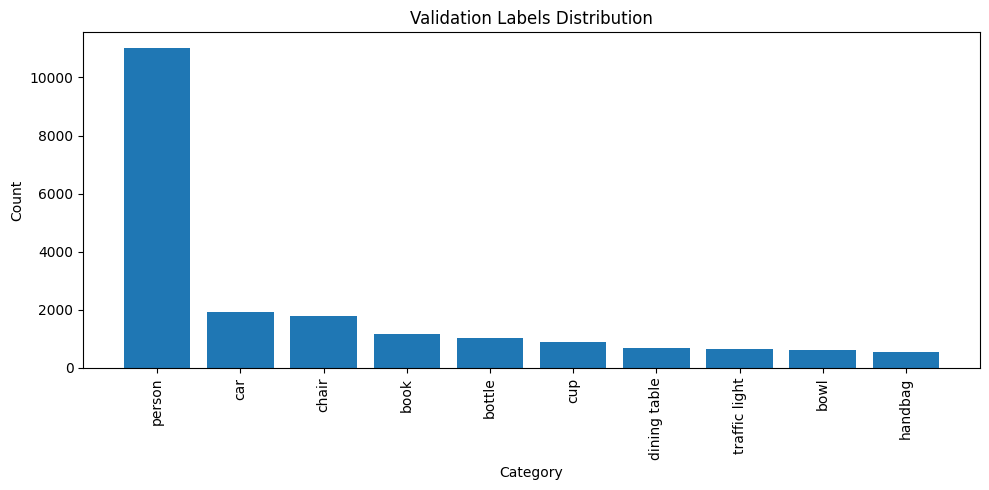

In [32]:
df_label_per_obj_val = pd.DataFrame(label_per_obj_val_top10, columns=['category_id'])
df_label_per_obj_val['category_name'] = df_label_per_obj_val['category_id'].map(cats_id_to_name)
df_label_per_obj_val['count'] = 1
df_label_per_obj_val = df_label_per_obj_val.groupby(['category_id', 'category_name']).count().reset_index()
df_label_per_obj_val = df_label_per_obj_val.sort_values(by='count', ascending=False)
# plot the graph
plt.figure(figsize=(10, 5))
plt.bar(df_label_per_obj_val['category_name'], df_label_per_obj_val['count'])
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Validation Labels Distribution')
plt.tight_layout()
plt.show()

In [34]:
df_label_per_obj_val

,category_id,category_name,count
0,1,person,11004
1,3,car,1932
7,62,chair,1791
9,84,book,1161
4,44,bottle,1025
5,47,cup,899
8,67,dining table,697
2,10,traffic light,637
6,51,bowl,626
3,31,handbag,540


In [10]:
# calculate the number of images in each category, store them in a dataframe
import pandas as pd

def get_num_images_per_category(img_id_w_bb, label_per_obj):
    num_images_per_category = {}
    for i in range(len(label_per_obj)):
        if label_per_obj[i] not in num_images_per_category:
            num_images_per_category[label_per_obj[i]] = set()
        num_images_per_category[label_per_obj[i]].add(img_id_w_bb[i][1])

    num_images_per_category = {key: len(value) for key, value in num_images_per_category.items()}

    # create dataframe

    df = pd.DataFrame.from_dict(num_images_per_category, orient='index', columns=['num_images'])
    df.index.name = 'category_id'
    df.reset_index(inplace=True)
    df['category_name'] = df['category_id'].map(cats_id_to_name)
    df = df[['category_id', 'category_name', 'num_images']]
    df = df.sort_values(by='num_images', ascending=False)
    df = df.reset_index(drop=True)
    return df

df_train = get_num_images_per_category(img_id_w_bb_train_top10, label_per_obj_train_top10)
df_val = get_num_images_per_category(img_id_w_bb_val_top10, label_per_obj_val_top10)

In [11]:
df_train

,category_id,category_name,num_images
0,1,person,64115
1,62,chair,12774
2,3,car,12251
3,67,dining table,11837
4,47,cup,9189
5,44,bottle,8501
6,51,bowl,7111
7,31,handbag,6841
8,84,book,5332
9,10,traffic light,4139


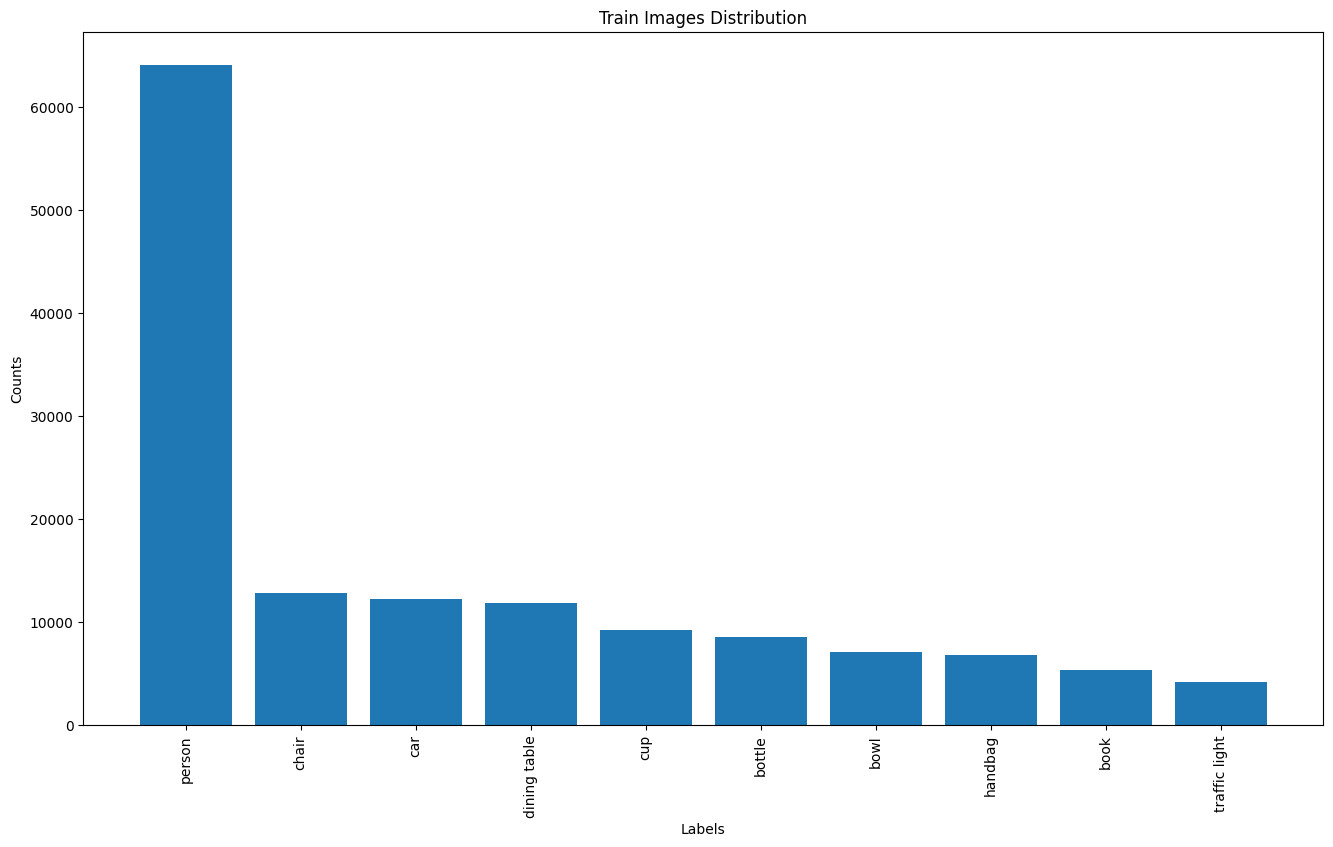

In [12]:
# plot a graph to see the distribution of labels
def plot_distribution_df(df, title):
    plt.figure(figsize=(16,9))
    plt.bar(df['category_name'], df['num_images'])
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.xticks(rotation=90)
    plt.show()

plot_distribution_df(df_train, 'Train Images Distribution')

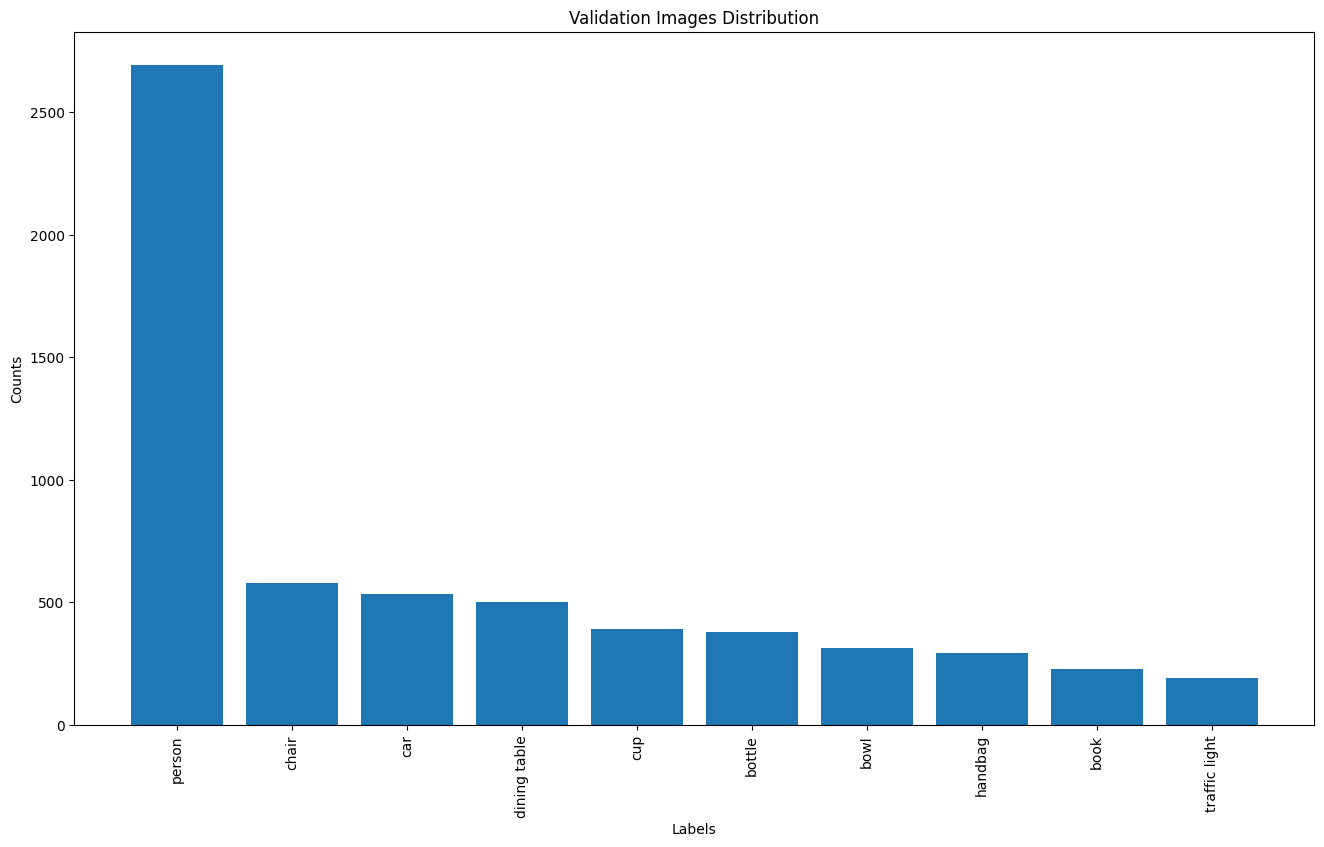

In [13]:
plot_distribution_df(df_val, 'Validation Images Distribution')

In [41]:
df_train['num_images']

0    64115
1    12774
2    12251
3    11837
4     9189
5     8501
6     7111
7     6841
8     5332
9     4139
Name: num_images, dtype: int64

We create our own subset of images from COCO

We reduce the number of images in the training set, such that the training set looks roughly balanced, yet reflecting the trend, that person is the majority category

We keep around 8000 images for person category

In [42]:
# filter person images to reduce number of images that including person to 8000

N_IMAGES_TO_KEEP = 7000

def filter_person_images(img_id_w_bb, label_per_obj):
    # get all image ids that have person
    person_ids = set()

    for i in range(len(label_per_obj)):
        if label_per_obj[i] == 1:
            person_ids.add(img_id_w_bb[i][1])

    # then randomly select 8000 images from the person ids
    person_ids = list(person_ids)
    np.random.shuffle(person_ids)
    not_keep_person_ids = set(person_ids[N_IMAGES_TO_KEEP:])

    # loop through the img_id_w_bb and label_per_obj and remove the images that are in not_person_ids
    indices_to_be_removed = []
    for i in range(len(img_id_w_bb)):
        if img_id_w_bb[i][1] in not_keep_person_ids:
            indices_to_be_removed.append(i)

    indices_to_be_removed = set(indices_to_be_removed)
    indices_to_be_kept = set(range(len(img_id_w_bb))) - indices_to_be_removed

    img_id_w_bb = [img_id_w_bb[i] for i in range(len(img_id_w_bb)) if i in indices_to_be_kept]
    label_per_obj = [label_per_obj[i] for i in range(len(label_per_obj)) if i in indices_to_be_kept]

    return img_id_w_bb, label_per_obj

In [43]:
img_id_w_bb_train_top10, label_per_obj_train_top10 = filter_person_images(img_id_w_bb_train_top10, label_per_obj_train_top10)

Distribution post cleaning

number of images

In [44]:
# compute number of images for each category in the training set after filtering

df_train_filtered = get_num_images_per_category(img_id_w_bb_train_top10, label_per_obj_train_top10)
df_train_filtered

,category_id,category_name,num_images
0,1,person,7000
1,67,dining table,6635
2,62,chair,5682
3,47,cup,4884
4,3,car,4680
5,51,bowl,4544
6,44,bottle,4461
7,84,book,3301
8,10,traffic light,1945
9,31,handbag,1340


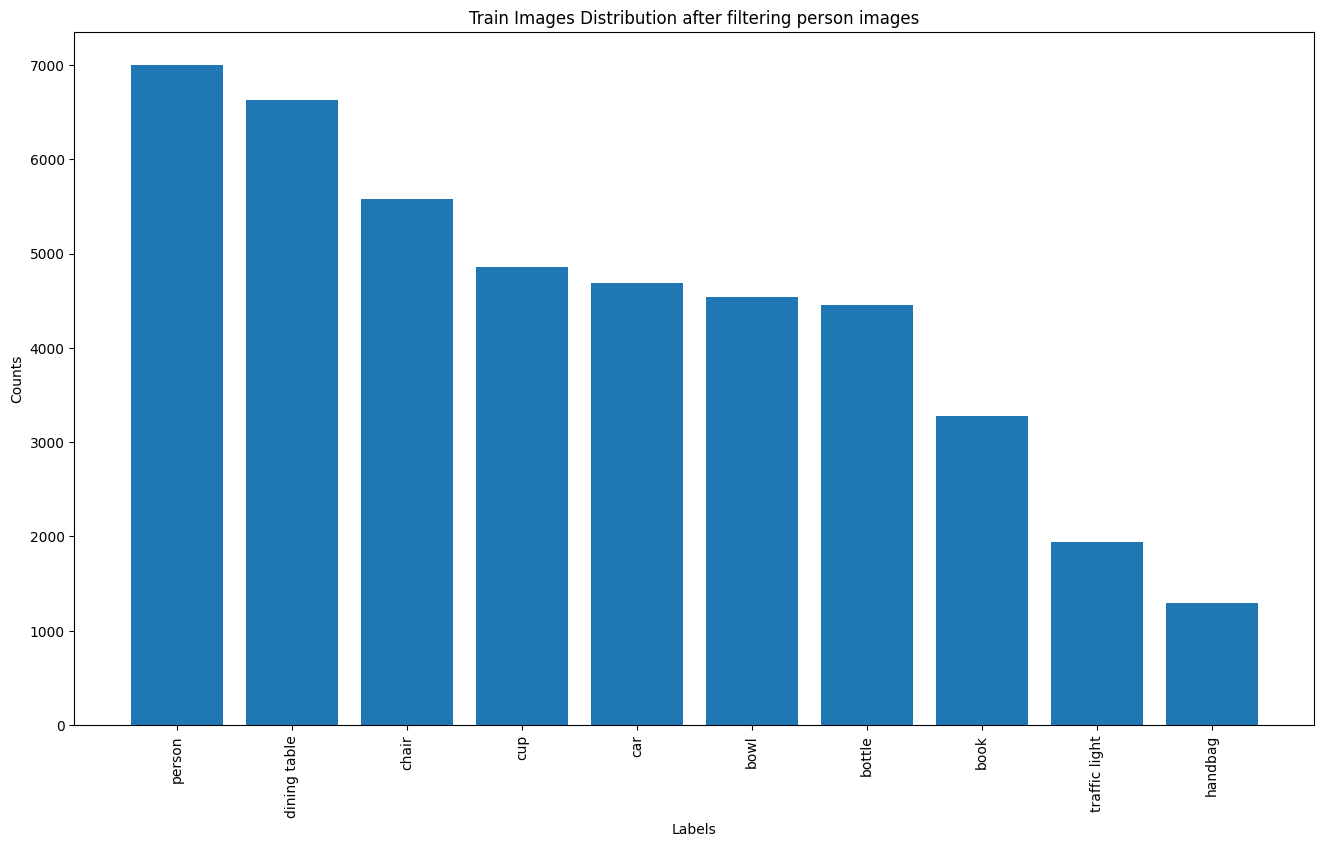

In [17]:
# plot a graph to see the distribution of labels
plot_distribution_df(df_train_filtered, 'Train Images Distribution after filtering person images')

In [18]:
# compute the number of annotations for each category in the filtered training set

def get_num_annotations_per_category(img_id_w_bb, label_per_obj):
    num_annotations_per_category = {}
    for i in range(len(label_per_obj)):
        if label_per_obj[i] not in num_annotations_per_category:
            num_annotations_per_category[label_per_obj[i]] = 0
        num_annotations_per_category[label_per_obj[i]] += 1

    # create dataframe
    df = pd.DataFrame.from_dict(num_annotations_per_category, orient='index', columns=['num_annotations'])
    df.index.name = 'category_id'
    df.reset_index(inplace=True)
    df['category_name'] = df['category_id'].map(cats_id_to_name)
    df = df[['category_id', 'category_name', 'num_annotations']]
    df = df.sort_values(by='num_annotations', ascending=False)
    df = df.reset_index(drop=True)
    return df

df_train_filtered_annotations = get_num_annotations_per_category(img_id_w_bb_train_top10, label_per_obj_train_top10)
df_train_filtered_annotations

,category_id,category_name,num_annotations
0,1,person,28967
1,3,car,16402
2,84,book,15558
3,62,chair,13659
4,44,bottle,12303
5,47,cup,9458
6,51,bowl,8455
7,67,dining table,7837
8,10,traffic light,6032
9,31,handbag,2140


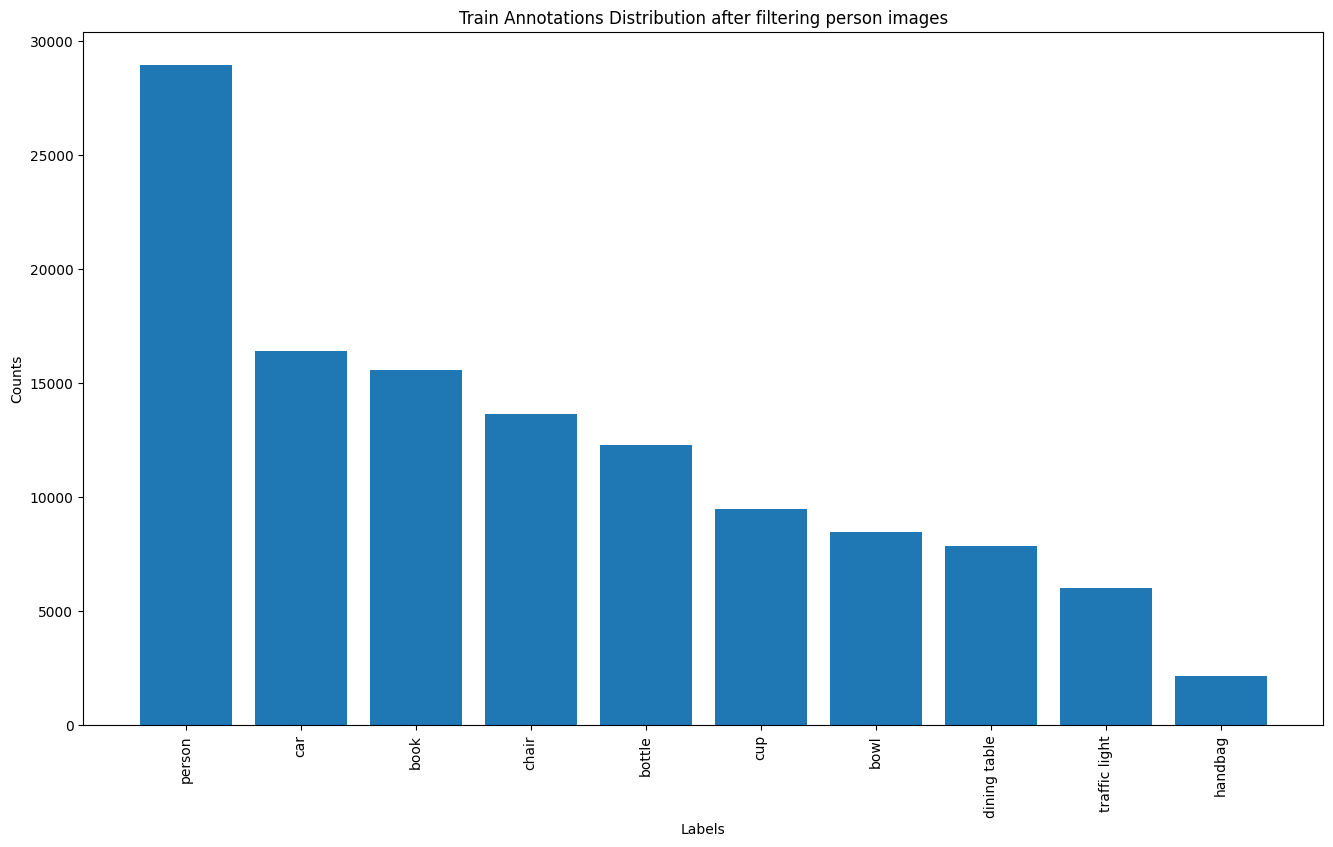

In [19]:
# plot a graph to see the distribution of labels
plt.figure(figsize=(16,9))
plt.bar(df_train_filtered_annotations['category_name'], df_train_filtered_annotations['num_annotations'])
plt.title('Train Annotations Distribution after filtering person images')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

In [20]:
df_train_filtered_annotations['num_annotations'].sum()

np.int64(120811)

In [21]:
img_id_w_bb_train_top10, label_per_obj_train_top10

([(80042, 574769, [25.49, 252.06, 19.36, 67.57]),
  (87261, 574769, [67.15, 324.79, 23.93, 29.54]),
  (201078, 574769, [103.32, 133.45, 231.03, 421.89]),
  (711104, 574769, [63.42, 286.13, 47.57, 27.38]),
  (1176778, 574769, [131.48, 445.77, 70.02, 118.08]),
  (82215, 309022, [55.5, 228.79, 7.09, 58.9]),
  (86614, 309022, [60.96, 230.25, 16.53, 59.92]),
  (91369, 309022, [75.44, 235.56, 16.63, 53.12]),
  (1488781, 309022, [67.43, 228.03, 8.84, 20.8]),
  (1534268, 309022, [343.39, 168.7, 26.05, 3.86]),
  (88176, 118113, [126.72, 355.82, 18.84, 45.91]),
  (1648773, 118113, [284.04, 180.23, 43.78, 14.87]),
  (1650346, 118113, [280.66, 191.71, 53.51, 12.59]),
  (1650582, 118113, [224.84, 235.82, 154.89, 64.75]),
  (1962899, 118113, [26.87, 374.69, 151.22, 151.22]),
  (1987441, 118113, [242.24, 102.22, 115.54, 50.69]),
  (1987697, 118113, [274.24, 202.43, 58.89, 12.92]),
  (1988448, 118113, [226.62, 197.56, 56.91, 17.22]),
  (1988599, 118113, [234.0, 121.68, 120.22, 47.4]),
  (91026, 193271

Save the filtered dataset

In [23]:
# save them to two pkl files

import pickle
from pathlib import Path

file_dir = Path('dataset/coco_top10_filtered_20250423')
if not file_dir.exists():
    file_dir.mkdir(parents=True)
    
with open(file_dir / 'img_id_w_bb_train_top10.pkl', 'wb') as f:
    pickle.dump(img_id_w_bb_train_top10, f)

with open(file_dir / 'label_per_obj_train_top10.pkl', 'wb') as f:
    pickle.dump(label_per_obj_train_top10, f)

In [31]:
len(img_id_w_bb_val_top10), len(label_per_obj_val_top10)

(20312, 20312)

In [32]:
with open(file_dir / 'img_id_w_bb_val_top10.pkl', 'wb') as f:
    pickle.dump(img_id_w_bb_val_top10, f)
with open(file_dir / 'label_per_obj_val_top10.pkl', 'wb') as f:
    pickle.dump(label_per_obj_val_top10, f)

---

SKIP

In [ ]:
# we look at the size of the bounding box and remove the ones that are too small

AREA_THRESHOLD = 1200
def filter_bboxes(img_id_w_bb, label_per_obj):
    filtered_img_id_w_bb = []
    filtered_label_per_obj = []

    for i in range(len(img_id_w_bb)):
        x, y, w, h = img_id_w_bb[i][2]
        area = w * h
        if area > AREA_THRESHOLD:
            filtered_img_id_w_bb.append(img_id_w_bb[i])
            filtered_label_per_obj.append(label_per_obj[i])

    return filtered_img_id_w_bb, filtered_label_per_obj

img_id_w_bb_train_top10_filtered, label_per_obj_train_top10_filtered = filter_bboxes(img_id_w_bb_train_top10, label_per_obj_train_top10)
img_id_w_bb_val_top10_filtered, label_per_obj_val_top10_filtered = filter_bboxes(img_id_w_bb_val_top10, label_per_obj_val_top10)

len(img_id_w_bb_train_top10_filtered), len(label_per_obj_train_top10_filtered), len(img_id_w_bb_val_top10_filtered), len(label_per_obj_val_top10_filtered)

(290899, 290899, 12537, 12537)

---

V2: We create a desire distribution of images

pure intuition, but reference to the distribution after removing majority of the images involving person labelling

In [45]:
# filter person images to reduce number of images that including person to 8000

from copy import deepcopy

N_IMAGES_TO_KEEP = {
    1: 6000,
    67: 4000,
    62: 3000,
    47: 2500,
    3: 2400,
    51: 2200,
    44: 2000,
    84: 1800,
    10: 1300,
    31: 1000
}

def filter_images(img_id_w_bb, label_per_obj):
    id_keys = list(N_IMAGES_TO_KEEP.keys())

    _img_id_w_bb = deepcopy(img_id_w_bb)
    _label_per_obj = deepcopy(label_per_obj)

    for id in id_keys:
        # get all image ids that have that categories
        cat_ids = set()

        for i in range(len(_label_per_obj)):
            if _label_per_obj[i] == id:
                cat_ids.add(_img_id_w_bb[i][1])

    
        # then randomly select N images if there is too much images for that categories
        cat_ids = list(cat_ids)
        np.random.shuffle(cat_ids)
        not_keep_cat_ids = set(cat_ids[N_IMAGES_TO_KEEP[id]:])

        if len(not_keep_cat_ids) == 0:
            print('skipping category id: {}'.format(id))
            continue

        # loop through the img_id_w_bb and label_per_obj and remove the images that are in not_person_ids
        indices_to_be_removed = []
        for i in range(len(_img_id_w_bb)):
            if _img_id_w_bb[i][1] in not_keep_cat_ids:
                indices_to_be_removed.append(i)

        if len(indices_to_be_removed) == 0:
            continue

        indices_to_be_removed = set(indices_to_be_removed)
        indices_to_be_kept = set(range(len(_img_id_w_bb))) - indices_to_be_removed

        _img_id_w_bb = [_img_id_w_bb[i] for i in range(len(img_id_w_bb)) if i in indices_to_be_kept]
        _label_per_obj = [_label_per_obj[i] for i in range(len(_label_per_obj)) if i in indices_to_be_kept]

    return _img_id_w_bb, _label_per_obj

In [46]:
img_id_w_bb_train_top10_filteredv2, label_per_obj_train_filteredv2 = filter_images(img_id_w_bb_train_top10, label_per_obj_train_top10)

skipping category id: 31


In [49]:
df_train_filtered = get_num_images_per_category(img_id_w_bb_train_top10_filteredv2, label_per_obj_train_filteredv2)
df_train_filtered

,category_id,category_name,num_images
0,1,person,4908
1,67,dining table,2640
2,62,chair,2474
3,3,car,2337
4,51,bowl,2002
5,47,cup,1958
6,44,bottle,1954
7,84,book,1800
8,10,traffic light,1300
9,31,handbag,942


In [48]:
df_train_filtered['num_images'].sum()

np.int64(22315)

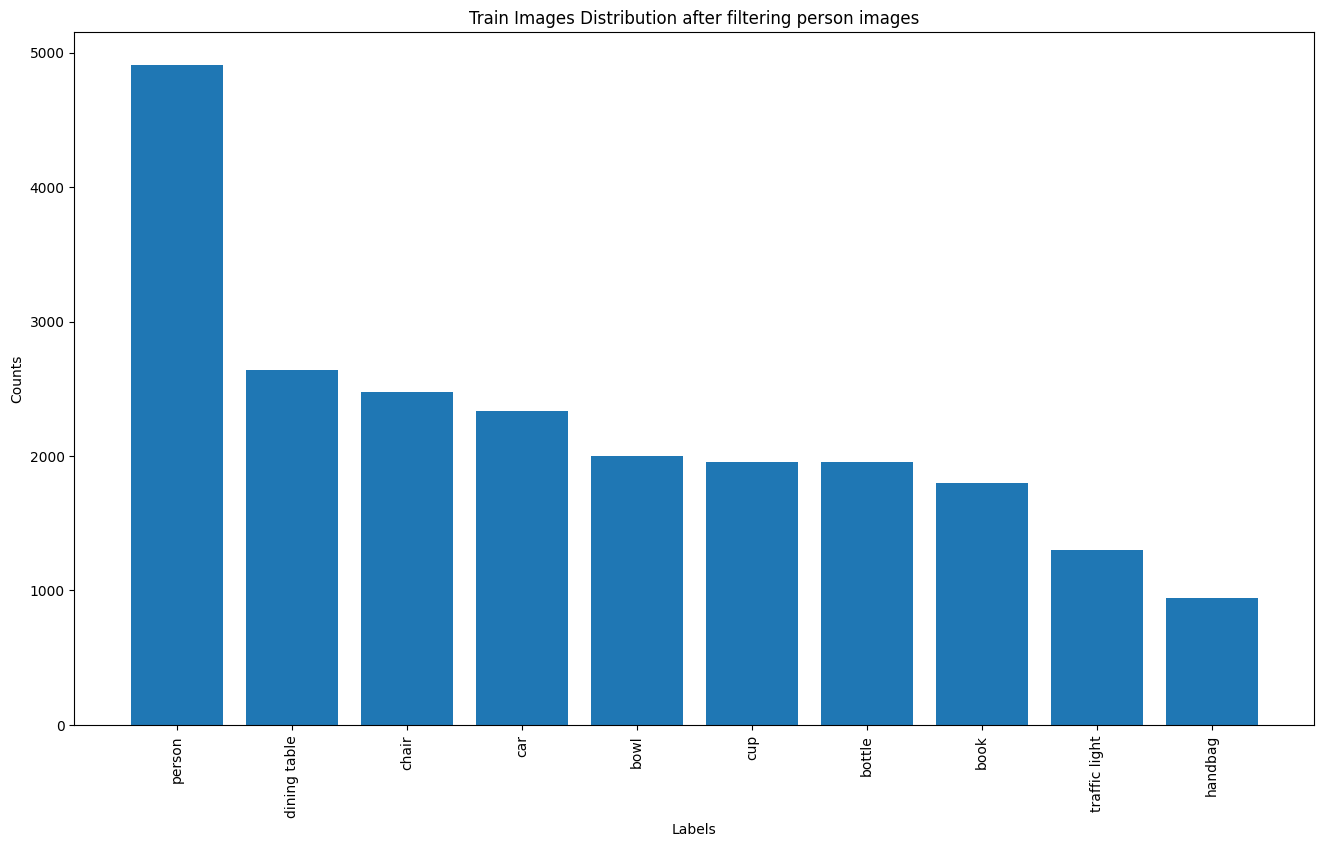

In [50]:
plot_distribution_df(df_train_filtered, 'Train Images Distribution after filtering person images')

save dataset

In [52]:
import pickle
from pathlib import Path

file_dir = Path('dataset/coco_top10_filtered_20250423')
if not file_dir.exists():
    file_dir.mkdir(parents=True)

with open(file_dir / 'img_id_w_bb_train_top10_v2.pkl', 'wb') as f:
    pickle.dump(img_id_w_bb_train_top10_filteredv2, f)

with open(file_dir / 'label_per_obj_train_top10_v2.pkl', 'wb') as f:
    pickle.dump(label_per_obj_train_filteredv2, f)